## Imports

In [1]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import silhouette_samples, silhouette_score

import seaborn as sns

import pandas as pd
import numpy as np
import random

## Defining global variables

In [2]:
window_size = 10
n_clusters = 2
sampling_ratio = 0.9 # Percentage of data to be sampled
N = 1000   # N is the number of initial data to be clustered.
K = sampling_ratio * N // 100  # K to be calculated as K/N is the sampling
                               # ratio, and N is the initial number of
                               # data to be clustered 

## Categorizing attacks into attack groups

In [3]:
DOS   = ['back', 'neptune', 'smurf', 'teardrop', 'land', 'pod']
Probe = ['satan', 'portsweep', 'ipsweep', 'nmap']
R2L   = ['warezmaster', 'warezclient', 'guess_passwd', 'imap',
         'multihop', 'phf', 'spy', 'ftp_write']
U2R   = ['rootkit', 'buffer_overflow', 'loadmodule', 'perl']

## Defining useful functions

In [4]:
# Function to create list of lists.

def init_list_of_objects(size):
    list_of_objects = list()
    for i in range(0,size):
        list_of_objects.append( list() )
    return list_of_objects

def init_list_of_dict(size):
    list_of_objects = list()
    for i in range(0,size):
        list_of_objects.append( dict() )
    return list_of_objects

# Defining our sampling probability    

def probability(e, center):
    norm_e = np.linalg.norm(e)
    norm_center = np.linalg.norm(center)
    return int(abs(1 - norm_e / norm_center) * 100)

# Defining our error function

def calculateErrorWithSample(e, sample, init_mean):
    sample = sample.append(e, ignore_index = True)
    sample_mean = calculateMean(sample)
    overall_mean = init_mean - sample_mean
    result = overall_mean.div(init_mean).replace(np.inf, 0)
    return  abs(result.mean()) * 100  

def calculateErrorWithoutSample(sample, init_mean):
    sample_mean = calculateMean(sample)
    overall_mean = init_mean - sample_mean
    result = overall_mean.div(init_mean).replace(np.inf, 0)
    return  abs(result.mean()) * 100  

def updateRankTable():
    # Do something here
    return

# calculating the mean for a giving cluster
def calculateMean(df):
        return df.mean(axis = 0)
    
def simpleRandomSampling(prob):
    a = random.randint(1, 100)
    if a < prob:
        return True
    return False

## Reading Data

In [5]:
# Reading and adjusting the data through header renaming and feature selection

data = pd.read_csv("KDDTrain.txt", sep =',', header = None)
data.columns = ["feature {}".format(i+1) for i in range (43)]
data = data.drop(data.columns[[0, 1, 2, 3, 8, 9, 11, 12, 14, 15, 16, 17, 18,
                               19, 20, 21, 24, 25, 26, 28, 30, 31, 32, 33,
                               34, 36, 37, 39, 40, 42]], axis = 1)

## Data Normalization

In [6]:
scaler = MinMaxScaler()
norm_array = scaler.fit_transform(data.loc[:, data.columns != 'feature 42'])
norm_data = pd.DataFrame(norm_array, columns = data.columns[:-1])

## Replacing attack names by numerical values

In [7]:
data['feature 42'] = data['feature 42'].replace(['normal'], 0)
data['feature 42'] = data['feature 42'].replace(DOS, 1)
data['feature 42'] = data['feature 42'].replace(Probe, 2)
data['feature 42'] = data['feature 42'].replace(R2L, 3)
data['feature 42'] = data['feature 42'].replace(U2R, 4)

## Taking a look into our data composition per label

In [8]:
print("Actual label groups:")
print(data['feature 42'].value_counts())

Actual label groups:
0    67343
1    45927
2    11656
3      995
4       52
Name: feature 42, dtype: int64


## Running the pseudo-code

C:\Users\adam_\AppData\Local\Temp/ipykernel_25864/1732065023.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sampled_df['cluster'] = kmeans.labels_


Clusters: 
0    710
1    290
Name: cluster, dtype: int64


[Text(0.5, 15.0, 'clusters'), Text(33.0, 0.5, 'actual')]

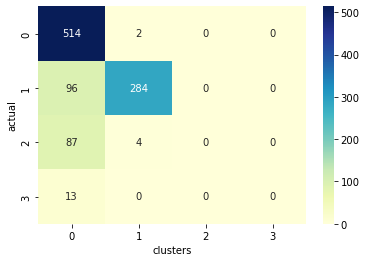

In [9]:
# taking the 1000 first rows of data for K-means algorithm.

sampled_df=norm_data.head(N)
kmeans = KMeans(n_clusters = n_clusters)
kmeans.fit(sampled_df)
labels = kmeans.predict(sampled_df)
centroids = kmeans.cluster_centers_

sampled_df['cluster'] = kmeans.labels_
print('Clusters: ')
print(sampled_df['cluster'].value_counts())

results = confusion_matrix(data['feature 42'].head(N), labels)
s = sns.heatmap(results, cmap="YlGnBu", annot=True, fmt="d")
s.set(xlabel='clusters', ylabel='actual')

# Now for each cluster, sample k/n items while using the given probability.
    

In [10]:
import timeit

start = timeit.default_timer()

clusters_size = sampled_df['cluster'].value_counts()

clusters = init_list_of_objects(n_clusters)

for i in range(N):
    clusters[sampled_df['cluster'][i]].append(i)

initial_means = []

for i in range(n_clusters):
    initial_means.append(calculateMean(norm_data.iloc[clusters[i]]))

cluster_sample = init_list_of_objects(n_clusters)

for i in range(n_clusters):
    j = 0
    while len(cluster_sample[i]) < int(sampling_ratio * len(clusters[i])):
        if (clusters[i][j] not in cluster_sample[i]):
            if simpleRandomSampling(probability(norm_data.iloc[clusters[i][j]], centroids[i])):
                cluster_sample[i].append(clusters[i][j])
        j = j + 1
        if j == len(clusters[i]):
            j = 0

rank_table = init_list_of_dict(n_clusters)

samples_means = []

for i in range(n_clusters):
    samples_means.append(calculateMean(norm_data.iloc[cluster_sample[i]]))

for i in range(n_clusters):
    for j in range(len(cluster_sample[i])):
        rank_table[i][cluster_sample[i][j]] = calculateErrorWithoutSample(norm_data.iloc[(cluster_sample[i][:j] + cluster_sample[i][j+1:])],
                                                                          samples_means[i])

for i in range(n_clusters):
    rank_table[i] = dict(
        sorted(rank_table[i].items(), key=lambda item: item[1]))

############################################ Code to retrieve dict values ##################################################

# dict_pairs = rank_table[0].items()
# pairs_iterator = iter(dict_pairs)
# for i in range(len(cluster_sample[0])):
#     first_pair = next(pairs_iterator)
#     print(" pair: ", first_pair)

M = N


while M < len(norm_data):
    pred = kmeans.predict(norm_data.iloc[M: M+1])
    error = calculateErrorWithSample(
        norm_data.iloc[M: M+1], norm_data.iloc[cluster_sample[pred[0]]], initial_means[pred[0]])
    error_out = calculateErrorWithoutSample(
        norm_data.iloc[cluster_sample[pred[0]]], initial_means[pred[0]])
    if error < error_out:
        if simpleRandomSampling(probability(norm_data.iloc[M], centroids[pred[0]])):
            cluster_sample[pred[0]].append(M)
            cluster_sample[pred[0]].remove(list(rank_table[pred[0]].keys())[0])
            del rank_table[pred[0]][list(rank_table[pred[0]].keys())[0]]
    M = M + 1
    if M % window_size == 0:
        print(M)
        samples_means = []
        for i in range(n_clusters):
            samples_means.append(calculateMean(
                norm_data.iloc[cluster_sample[i]]))

        for i in range(n_clusters):
            for j in range(len(cluster_sample[i])):
                rank_table[i][cluster_sample[i][j]] = calculateErrorWithoutSample(norm_data.iloc[(cluster_sample[i][:j] + cluster_sample[i][j+1:])],
                                                                                  samples_means[i])

        for i in range(n_clusters):
            rank_table[i] = dict(
                sorted(rank_table[i].items(), key=lambda item: item[1]))


stop = timeit.default_timer()
execution_time = stop - start

print("Program Executed in " + str(execution_time)) # Execution time in sec

KeyboardInterrupt: 

For n_clusters = 5 The average silhouette_score is : 0.6742690570247563


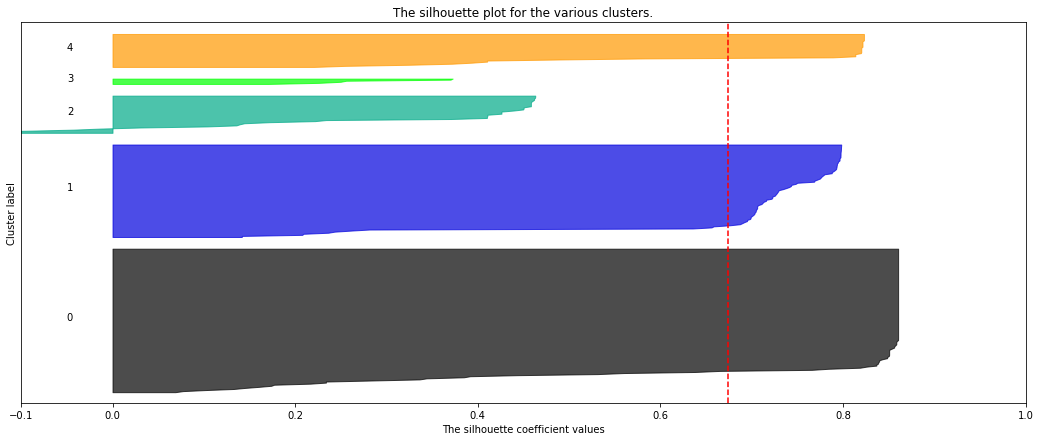

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

cluster_labels = []
X = []

for i in range(n_clusters):
    for j in range(len(cluster_sample[i])):
        X.append(norm_data.iloc[cluster_sample[i][j]].values)
        cluster_labels.append(i)

range_n_clusters = [5]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1) = plt.subplots(1, 1)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

plt.show()


